In [1]:
import pandas as pd 
import numpy as np 
import boto3
import io
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pprint import pprint 
import plotly.express as px

In [2]:
# Data loading
# Data exploration
# Data cleaning and pre-processing 
# Save Data to csv file for ML training 

In [3]:
# boto3 client to get S3 data
s3_client = boto3.client('s3')
bucket_name='aws-ml-blog-sagemaker-census-segmentation'

# get a list of objects in the bucket
obj_list=s3_client.list_objects(Bucket=bucket_name)

# print objects in S3 bucket
files=[]
for contents in obj_list['Contents']:
    files.append(contents['Key'])
    
file_name=files[0]

In [4]:
# passing in the bucket and file name
data_object = s3_client.get_object(Bucket=bucket_name, Key=file_name)

In [5]:
data_body = data_object["Body"].read()
data_stream = io.BytesIO(data_body)

# create a dataframe
df = pd.read_csv(data_stream, header=0, delimiter=",") 
df.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [6]:
# provides a quantitative summary for each column (count, mean, std, min, max, etc)
df.describe()

,CensusId,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,3220.000000,3.220000e+03,3.220000e+03,3.220000e+03,3220.000000,3220.000000,3220.000000,3220.000000,3220.000000,3220.000000,...,3220.000000,3220.000000,3220.000000,3220.000000,3.220000e+03,3220.000000,3220.000000,3220.000000,3220.000000,3220.000000
mean,31393.605280,9.940935e+04,4.889694e+04,5.051241e+04,11.011522,75.428789,8.665497,1.723509,1.229068,0.082733,...,3.323509,1.612733,4.631770,23.278758,4.559352e+04,74.219348,17.560870,7.931801,0.288106,8.094441
std,16292.078954,3.193055e+05,1.566813e+05,1.626620e+05,19.241380,22.932890,14.279122,7.253115,2.633079,0.734931,...,3.756096,1.670988,3.178772,5.600466,1.496995e+05,7.863188,6.510354,3.914974,0.455137,4.096114
min,1001.000000,8.500000e+01,4.200000e+01,4.300000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.900000,6.200000e+01,25.000000,5.800000,0.000000,0.000000,0.000000
25%,19032.500000,1.121800e+04,5.637250e+03,5.572000e+03,1.900000,64.100000,0.500000,0.100000,0.200000,0.000000,...,1.400000,0.900000,2.700000,19.500000,4.550750e+03,70.500000,13.100000,5.400000,0.100000,5.500000
50%,30024.000000,2.603500e+04,1.293200e+04,1.305700e+04,3.900000,84.100000,1.900000,0.300000,0.500000,0.000000,...,2.400000,1.300000,3.900000,23.000000,1.050800e+04,75.700000,16.200000,6.900000,0.200000,7.600000
75%,46105.500000,6.643050e+04,3.299275e+04,3.348750e+04,9.825000,93.200000,9.600000,0.600000,1.200000,0.000000,...,4.000000,1.900000,5.600000,26.800000,2.863275e+04,79.700000,20.500000,9.400000,0.300000,9.900000
max,72153.000000,1.003839e+07,4.945351e+06,5.093037e+06,99.900000,99.800000,85.900000,92.100000,41.600000,35.300000,...,71.200000,39.100000,37.200000,44.000000,4.635465e+06,88.300000,66.200000,36.600000,9.800000,36.500000


In [7]:
print(f'Number of rows of DataFrame {df.shape[0]}')
print(f'Number of columns of DataFrame {df.shape[1]}')

Number of rows of DataFrame 3220
Number of columns of DataFrame 37


In [8]:
# get datatype for each feature (string, float, int, bool)
pprint(df.columns.to_series().groupby(df.dtypes).groups)
# State and County are object, o/w everything is float or int


{dtype('int64'): Index(['CensusId', 'TotalPop', 'Men', 'Women', 'Citizen', 'IncomePerCap',
       'IncomePerCapErr', 'Employed'],
      dtype='object'),
 dtype('float64'): Index(['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific', 'Income',
       'IncomeErr', 'Poverty', 'ChildPoverty', 'Professional', 'Service',
       'Office', 'Construction', 'Production', 'Drive', 'Carpool', 'Transit',
       'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute', 'PrivateWork',
       'PublicWork', 'SelfEmployed', 'FamilyWork', 'Unemployment'],
      dtype='object'),
 dtype('O'): Index(['State', 'County'], dtype='object')}


In [9]:
# find null values in DataFrame
if df.isnull().sum().any() == False:
    print('Data is Clean, No Null values found')
else:
    print('Found Null Values')

Found Null Values


In [10]:
# Null-Values found, lets see the percentage for each column 
df.isnull().sum() / len(df) * 100 

CensusId           0.000000
State              0.000000
County             0.000000
TotalPop           0.000000
Men                0.000000
Women              0.000000
Hispanic           0.000000
White              0.000000
Black              0.000000
Native             0.000000
Asian              0.000000
Pacific            0.000000
Citizen            0.000000
Income             0.031056
IncomeErr          0.031056
IncomePerCap       0.000000
IncomePerCapErr    0.000000
Poverty            0.000000
ChildPoverty       0.031056
Professional       0.000000
Service            0.000000
Office             0.000000
Construction       0.000000
Production         0.000000
Drive              0.000000
Carpool            0.000000
Transit            0.000000
Walk               0.000000
OtherTransp        0.000000
WorkAtHome         0.000000
MeanCommute        0.000000
Employed           0.000000
PrivateWork        0.000000
PublicWork         0.000000
SelfEmployed       0.000000
FamilyWork         0

In [11]:
# given the results above, [ChildPoverty, IncomeErr, Income] contain null values 
# less than 1% of df columns have null values 
nan_values = df[df.columns[df.isnull().any()]]
print(nan_values)

       Income  IncomeErr  ChildPoverty
0     51281.0     2391.0          18.6
1     50254.0     1263.0          19.2
2     32964.0     2973.0          45.3
3     38678.0     3995.0          27.9
4     45813.0     3141.0          27.2
...       ...        ...           ...
3215  16948.0     1234.0          56.1
3216  18104.0     3771.0          58.1
3217  17818.0     1255.0          68.3
3218  15627.0     1836.0          62.1
3219  14708.0     1245.0          56.3

[3220 rows x 3 columns]


<AxesSubplot:>

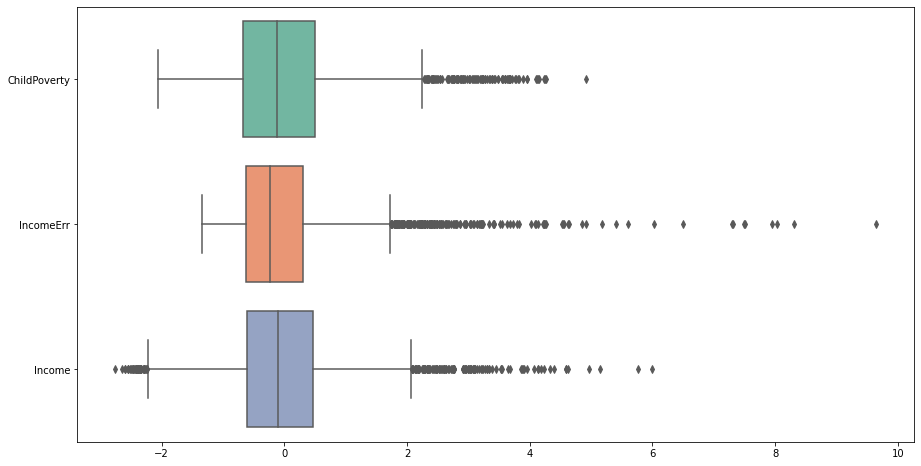

In [29]:
# Null values can be dropped or replaced by Median, Mean, or K Nearest Neighbor
# Before filling Null values, analyz the data distribution for [ChildPoverty, IncomeErr, Income]

null_col = ['ChildPoverty', 'IncomeErr', 'Income']
plt.subplots(figsize=(15,8))
sns.boxplot(data=df_scaled[null_col], orient="h", palette="Set2")

In [13]:
# given the boxplot, there's alot of extreme values in IncomeErr and Income
# fill in null values with median, not mean (mean is sensitive to extreme values)
df = df.fillna(df.median())

In [14]:
# Verify if DataFrame still has null values 
if df.isnull().sum().any() == False:
    print('Data is Clean, No Null values found')
else:
    print('Found Null Values')

Data is Clean, No Null values found


In [31]:
# Reduce 37 columns due to curse of dimensionality 
df1 = df.copy()

In [32]:
df1.columns

Index(['TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native',
       'Asian', 'Pacific', 'Citizen', 'Income', 'IncomeErr', 'IncomePerCap',
       'IncomePerCapErr', 'Poverty', 'ChildPoverty', 'Professional', 'Service',
       'Office', 'Construction', 'Production', 'Drive', 'Carpool', 'Transit',
       'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Employed',
       'PrivateWork', 'PublicWork', 'SelfEmployed', 'FamilyWork',
       'Unemployment'],
      dtype='object')

In [36]:
df1['population'] = df1.Men + df1.Women

df['un'] = df1['population'] - df.Citizen
df['un'] 

Alabama-Autauga          14496
Alabama-Baldwin          47426
Alabama-Barbour           6218
Alabama-Bibb              5109
Alabama-Blount           15365
                         ...  
Puerto Rico-Vega Baja    13202
Puerto Rico-Vieques       2045
Puerto Rico-Villalba      6227
Puerto Rico-Yabucoa       8355
Puerto Rico-Yauco         8813
Name: un, Length: 3220, dtype: int64

In [59]:
pct_pop = df1.Employed/ df1.TotalPop
pct_pop.sort_values(ascending=False).head()

Alaska-Aleutians East Borough        0.762409
Hawaii-Kalawao                       0.752941
Alaska-Skagway Municipality          0.676677
Alaska-Aleutians West Census Area    0.666256
Wyoming-Teton                        0.640850
dtype: float64

In [16]:
# Combine 'State' and 'County' and index the column
df.index = df['State'] + '-' + df['County']


In [17]:
# drop the 'CensusId', 'State', 'County' columns
df = df.drop(['CensusId', 'State', 'County'], axis=1)

<AxesSubplot:>

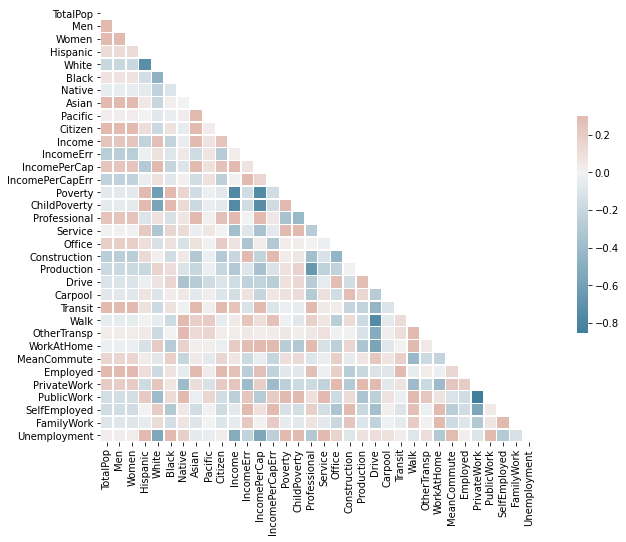

In [18]:
# compute corr array and generate a mask for the upper triangle
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(15,8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# plt heatmap with mask and ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# looks like [Poverty, ChildPoverty] are highly correlated with [Income, Income Cap]

<AxesSubplot:>

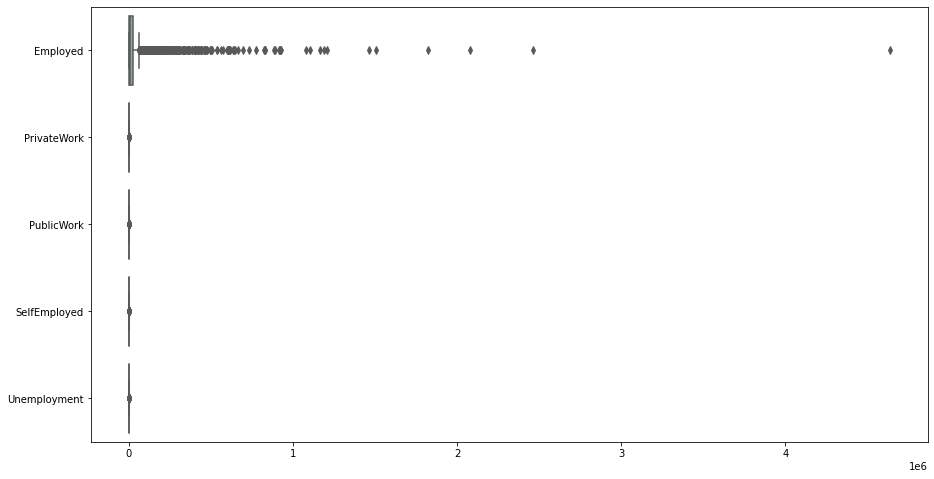

In [19]:
# plot a horizontal boxplot, helps identify [25, 50, 75%], mean, median, and outliers 
occupation_list = ['Employed','PrivateWork','PublicWork','SelfEmployed', 'Unemployment']

plt.subplots(figsize=(15,8))
sns.boxplot(data=df[occupation_list], orient="h", palette="Set2")

<AxesSubplot:ylabel='Count'>

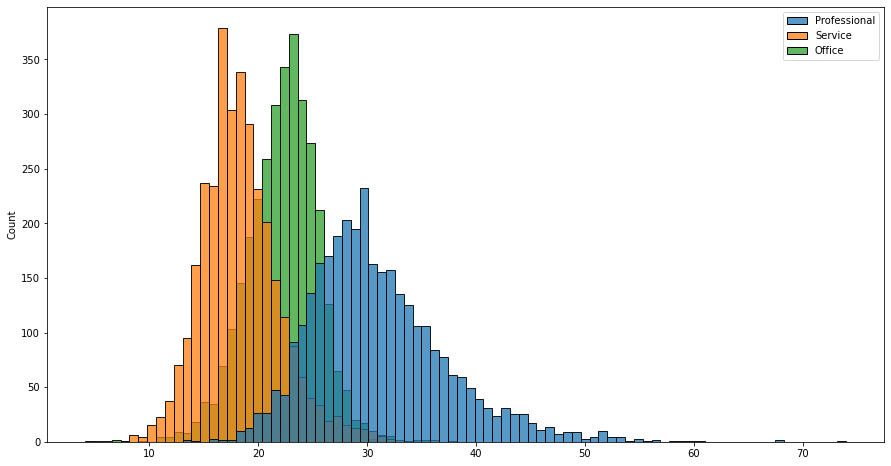

In [20]:
# workers_list features historgram 
workers_list = ['Professional', 'Service', 'Office']
plt.subplots(figsize=(15,8))
sns.histplot(df[workers_list].astype(float))
#  typical county has around 30% Professional workers

In [21]:
print(df.columns)

Index(['TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native',
       'Asian', 'Pacific', 'Citizen', 'Income', 'IncomeErr', 'IncomePerCap',
       'IncomePerCapErr', 'Poverty', 'ChildPoverty', 'Professional', 'Service',
       'Office', 'Construction', 'Production', 'Drive', 'Carpool', 'Transit',
       'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Employed',
       'PrivateWork', 'PublicWork', 'SelfEmployed', 'FamilyWork',
       'Unemployment'],
      dtype='object')


In [22]:
print(1+2)

3


<AxesSubplot:ylabel='Count'>

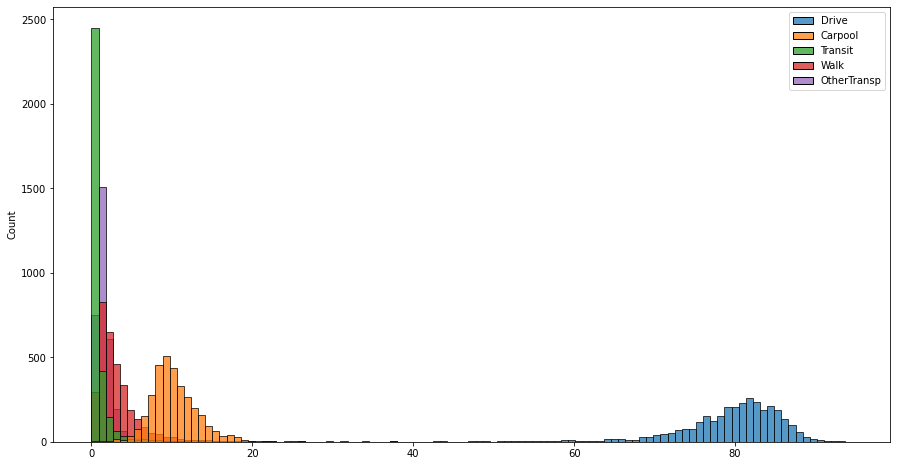

In [23]:
# transportation features historgram 
transport_list = ['Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp']
plt.subplots(figsize=(15,8))
sns.histplot(df[transport_list].astype(float))


<AxesSubplot:ylabel='Count'>

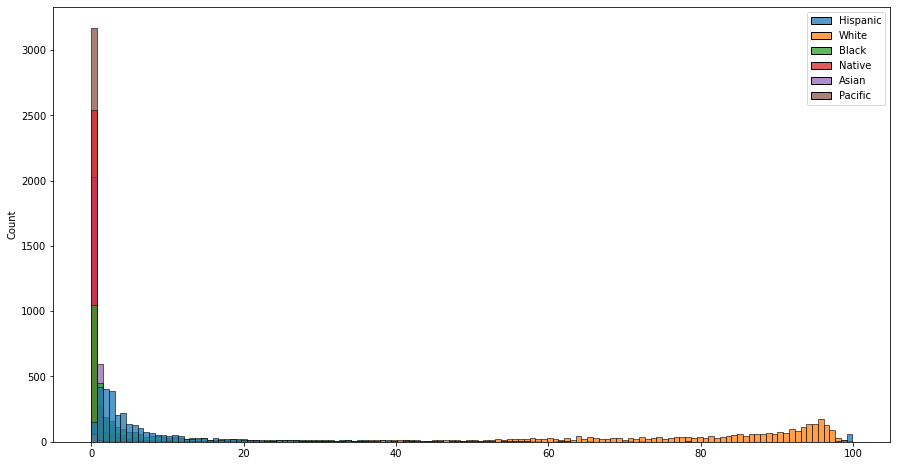

In [24]:
# race features historgram  
race_list = ['Hispanic', 'White', 'Black', 'Native', 'Asian','Pacific']
plt.subplots(figsize=(15,8))
sns.histplot(df[race_list].astype(float))

In [25]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# transform and fit the data  in Standardize features by removing the mean and scaling to unit variance

# inittiate the StandardScaler
scaler = StandardScaler()

# fit and transform Standardize features as pandas DataFrame
df_scaled = pd.DataFrame(scaler.fit_transform(df.astype(float)))
print(df_scaled.head())



         0         1         2         3         4         5         6   \
0 -0.138410 -0.141404 -0.135495 -0.437226  0.016189  0.688840 -0.182503   
1  0.299796  0.296298  0.303096 -0.338465  0.334559  0.058451 -0.154924   
2 -0.227020 -0.219588 -0.234126 -0.333267 -1.274734  2.664058 -0.210082   
3 -0.240576 -0.235061 -0.245833 -0.458018 -0.040507  0.891965 -0.182503   
4 -0.130614 -0.130125 -0.131055 -0.125349  0.543898 -0.501894 -0.196292   

         7        8         9   ...        24        25        26        27  \
0 -0.087010 -0.11259 -0.142428  ... -0.751831 -0.187184 -0.890976  0.575263   
1 -0.200963 -0.11259  0.379156  ... -0.618693 -0.127329 -0.230241  0.557405   
2 -0.314915 -0.11259 -0.240001  ... -0.405673 -0.067475 -0.953903  0.146661   
3 -0.428868 -0.11259 -0.255697  ... -0.725203 -0.067475 -1.237075  0.986007   
4 -0.428868 -0.11259 -0.134529  ... -0.645321 -0.725871 -0.733658  2.075372   

         28        29        30        31        32        33  
0 -0.14436

In [26]:
# rename the columns and define index 
df_scaled.columns = df.columns
df_scaled.index = df.index
print(df_scaled.columns)
print(df_scaled.index)


Index(['TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native',
       'Asian', 'Pacific', 'Citizen', 'Income', 'IncomeErr', 'IncomePerCap',
       'IncomePerCapErr', 'Poverty', 'ChildPoverty', 'Professional', 'Service',
       'Office', 'Construction', 'Production', 'Drive', 'Carpool', 'Transit',
       'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Employed',
       'PrivateWork', 'PublicWork', 'SelfEmployed', 'FamilyWork',
       'Unemployment'],
      dtype='object')
Index(['Alabama-Autauga', 'Alabama-Baldwin', 'Alabama-Barbour', 'Alabama-Bibb',
       'Alabama-Blount', 'Alabama-Bullock', 'Alabama-Butler',
       'Alabama-Calhoun', 'Alabama-Chambers', 'Alabama-Cherokee',
       ...
       'Puerto Rico-Toa Alta', 'Puerto Rico-Toa Baja',
       'Puerto Rico-Trujillo Alto', 'Puerto Rico-Utuado',
       'Puerto Rico-Vega Alta', 'Puerto Rico-Vega Baja', 'Puerto Rico-Vieques',
       'Puerto Rico-Villalba', 'Puerto Rico-Yabucoa', 'Puerto Rico-Yauco'],
      dtype='object

In [27]:
# export the clean data into a csv file for ML model training 
df_scaled.to_csv('../inputs/population_seg.csv')

In [28]:
# implement this in another rep py file 
# PCA for dimensionality reduction
# Feature engineering/transform
# Clustering transformed data with k-means
# Use Kmeans clustering model and evalute model 
